In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pylab
import sys
# making sure the dl4mt module is on the path 
# -- this path depends upon the location where the notebook is running
# here it is assumed to be the day1/ directory
sys.path.append('../..')

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
%%writefile ../../dl4mt/logistic_regression.py
# Uncomment to save this cell to file in order to import it in later notebooks

import cPickle
import gzip
import os
import sys
import timeit

import numpy

import theano
import theano.tensor as T


class LogisticRegression(object):
    """Multi-class Logistic Regression Class

    The logistic regression is fully described by a weight matrix :math:`W`
    and bias vector :math:`b`. Classification is done by projecting data
    points onto a set of hyperplanes, the distance to which is used to
    determine a class membership probability.
    """

    def __init__(self, input, n_in, n_out):
        """ Initialize the parameters of the logistic regression

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
                      architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
                     which the datapoints lie

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
                      which the labels lie

        """
  
        # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
        self.W = theano.shared(
            value=numpy.zeros(
                (n_in, n_out),
                dtype=theano.config.floatX
            ),
            name='W',
            borrow=True
        )
        # initialize the biases b as a vector of n_out 0s
        self.b = theano.shared(
            value=numpy.zeros(
                (n_out,),
                dtype=theano.config.floatX
            ),
            name='b',
            borrow=True
        )

        # symbolic expression for computing the matrix of class-membership
        # probabilities
        # Where:
        # W is a matrix where column-k represent the separation hyperplane for
        # class-k
        # x is a matrix where row-j  represents input training sample-j
        # b is a vector where element-k represents the free parameter of
        # hyperplane-k
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # symbolic description of how to map p_y_given_x to the class with the maximum probability
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)
    
        # parameters of the model
        self.params = [self.W, self.b]

        # keep track of model input -- this will be useful for creating theano functions
        self.input = input

    def predict(self, X):
        # predict X using the parameters of this model
        return T.nnet.softmax(T.dot(X, self.W) + self.b)
        
    # TODO: put math in a separate cell with LaTeX + markdown -- 
    # TODO: implement this as a challenge -- add tests in the following cell to see if it's correct
    def negative_log_likelihood(self, y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label

        Note: we use the mean instead of the sum so that
              the learning rate is less dependent on the batch size
        """

        # y.shape[0] is (symbolically) the number of rows in y, i.e.,
        # number of examples (call it n) in the minibatch
        # T.arange(y.shape[0]) is a symbolic vector which will contain
        # [0,1,2,... n-1] T.log(self.p_y_given_x) is a matrix of
        # Log-Probabilities (call it LP) with one row per example and
        # one column per class LP[T.arange(y.shape[0]),y] is a vector
        # v containing [LP[0,y[0]], LP[1,y[1]], LP[2,y[2]], ...,
        # LP[n-1,y[n-1]]] and T.mean(LP[T.arange(y.shape[0]),y]) is
        # the mean (across minibatch examples) of the elements in v,
        # i.e., the mean log-likelihood across the minibatch.
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

    def errors(self, y):
        """Return a float representing the number of errors in the minibatch
        over the total number of examples of the minibatch ; zero one
        loss over the size of the minibatch

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label
        """

        # check if y has same dimension of y_pred
        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y', y.type, 'y_pred', self.y_pred.type)
            )
        # check if y is of the correct datatype
        if y.dtype.startswith('int'):
            # the T.neq operator returns a vector of 0s and 1s, where 1
            # represents a mistake in prediction
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()


Overwriting ../../dl4mt/logistic_regression.py


In [3]:
from dl4mt.logistic_regression import LogisticRegression

import theano
import theano.tensor as T

# TODO: switch to google code doc style

# this function is unique to this model, and initializes the functions and parameters we'll need for training
def initialize_logistic_regression(train_dataset, dev_dataset, learning_rate=0.1, batch_size=10):
    
    """Initializes the functions and parameters for a Logistic Regression model

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
                          gradient)

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

    """

    train_set_x, train_set_y = train_dataset
    valid_set_x, valid_set_y = dev_dataset

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] / batch_size

    # create the logistic regression model
    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch

    # generate symbolic variables for input (x and y represent a minibatch)
    x = T.matrix('x')  # data
    y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

    # TODO: parameterize  n_out outside the training function -- try to get directly from data
    n_in = train_set_x.get_value().shape[1]
    n_out = 12
    
    classifier = LogisticRegression(input=x, n_in=n_in, n_out=n_out)

    # the cost we minimize during training is the negative log likelihood of the model
    cost = classifier.negative_log_likelihood(y)

    validate_model_func = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    # compute the gradient of cost with respect to theta = (W,b)
    g_W = T.grad(cost=cost, wrt=classifier.W)
    g_b = T.grad(cost=cost, wrt=classifier.b)

    # specify how to update the parameters of the model as a list of
    # (variable, update expression) pairs.
    updates = [(classifier.W, classifier.W - learning_rate * g_W),
               (classifier.b, classifier.b - learning_rate * g_b)]

    # compiling a Theano function `train_model` that returns the cost, but in
    # the same time updates the parameter of the model based on the rules
    # defined in `updates`
    train_model_func = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    # return the classifier, the training and validation functions, and n_train_batches, n_valid_batches
    return (classifier, train_model_func, validate_model_func, n_train_batches, n_valid_batches)

In [4]:
%%writefile ../../dl4mt/training.py

# this function is shared by all day1 models which are trained with SGD
import timeit
import numpy

def train_model(train_model, n_train_batches, validate_model=None, n_valid_batches=0, training_epochs=25):
    
    # early-stopping parameters
    patience = 5000  # look at this many examples regardless
    patience_increase = 2  # wait this much longer when a new best is
                                  # found
    improvement_threshold = 0.995  # a relative improvement of this much is
                                  # considered significant
    validation_frequency = min(n_train_batches, patience / 2)
                                  # go through this many
                                  # minibatches before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

    best_validation_loss = numpy.inf
    test_score = 0.
    start_time = timeit.default_timer()

    done_looping = False
    epoch = 0
    while (epoch < training_epochs) and (not done_looping):
        epoch = epoch + 1
        mini_batch_costs = []
        for minibatch_index in xrange(n_train_batches):
            
            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index
            
            minibatch_avg_cost = train_model(minibatch_index)
            mini_batch_costs.append(minibatch_avg_cost)
            
            if validate_model is not None:
                if (iter + 1) % validation_frequency == 0:
                    # compute zero-one loss on validation set
                    validation_losses = [validate_model(i)
                                         for i in xrange(n_valid_batches)]
                    this_validation_loss = numpy.mean(validation_losses)

                    print(
                        'epoch %i, minibatch %i/%i, validation error %f %%' %
                        (
                            epoch,
                            minibatch_index + 1,
                            n_train_batches,
                            this_validation_loss * 100.
                        )
                    )

                    # if we got the best validation score until now
                    if this_validation_loss < best_validation_loss:
                        #improve patience if loss improvement is good enough
                        if this_validation_loss < best_validation_loss *  \
                           improvement_threshold:
                            patience = max(patience, iter * patience_increase)

                        best_validation_loss = this_validation_loss


                if patience <= iter:
                    done_looping = True
                    break
         
        print(
                'epoch %i, average training cost %0.2f' %
                (
                    epoch,
                    numpy.mean(mini_batch_costs)
                )
        )
                

    end_time = timeit.default_timer()
    print('Optimization complete!')
    if best_validation_loss < numpy.inf:
        print("Best validation score: %f %%") % (best_validation_loss * 100.)


Overwriting ../../dl4mt/training.py


In [5]:
%%writefile ../../dl4mt/datasets.py
# Uncomment to save this cell to file in order to import it in later notebooks

import theano
import theano.tensor as T
import numpy as np
from fuel.datasets import H5PYDataset

def create_hstacked_vectors(index_path, seqs):
    # load the index, map the seqs (word indices) through the index, hstack, then cast the results to np.array
    index = np.load(index_path)
    
    working_index = np.load(index_path)
    return np.array([np.hstack([index[idx] for idx in seq]) for seq in seqs])

# load a portion of a fuel dataset
def load_fuel_dataset(filename, which_sets=None):
#     TODO: if which_sets is not None return all sets

    X, y = H5PYDataset(
        filename, which_sets=which_sets,
        sources=['instances', 'targets'], load_in_memory=True).data_sources
    
    # make sure y is 0-dimensional
    y = y.ravel()
    
    return (X,y)
    
    
def shared_dataset(X, y, borrow=True, cast_y=True):
    """ Function that loads the dataset into shared variables

    The reason we store our dataset in shared variables is to allow
    Theano to copy it into the GPU memory (when code is run on GPU).
    Since copying data into the GPU is slow, copying a minibatch everytime
    is needed (the default behaviour if the data is not in a shared
    variable) would lead to a large decrease in performance.
    """

    shared_x = theano.shared(np.asarray(X,
                                           dtype=theano.config.floatX), borrow=borrow)
    shared_y = theano.shared(np.asarray(y,
                                           dtype=theano.config.floatX), borrow=borrow)
 
    # note that shared_y is cast to int because it is used as a vector of indices
    if cast_y:
        return shared_x, T.cast(shared_y, 'int32')
    return shared_x, shared_y

def prep_dataset(path, index_path, which_sets=[], cutoff=None, cast_y=True):
    X, y = load_fuel_dataset(path, which_sets=which_sets)
    if cutoff is not None:
        X = X[:cutoff]
        y = y[:cutoff]

    # extract windows
    X = create_hstacked_vectors(index_path, X)

    # make shared dataset
    return shared_dataset(X, y, cast_y=cast_y)

Overwriting ../../dl4mt/datasets.py


In [35]:
import os

from dl4mt.datasets import prep_dataset
from dl4mt.training import train_model

# location of our datasets
DATASET_LOCATION = '../../datasets/'

# the pos dataset consists of windows around words
POS_DATASET_NAME = 'brown_pos_dataset.hdf5'
POS_DATASET_PATH = os.path.join(DATASET_LOCATION, POS_DATASET_NAME)

WORD_BY_WORD_MATRIX = 'brown.word-by-word.normalized.npy'
# LSI matrix instead of word-by-word
# WORD_BY_WORD_MATRIX = 'brown.lsi-index.npy'
VECTOR_INDEX_PATH = os.path.join(DATASET_LOCATION, WORD_BY_WORD_MATRIX)

# the cutoff for the maximum number of training and dev examples
CUTOFF = 50000
  
train_dataset = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['train'], cutoff=CUTOFF)
dev_dataset = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['dev'], cutoff=CUTOFF)

# get the functions and params that we need for our models
initialization_data = initialize_logistic_regression(train_dataset, dev_dataset,
                                                     learning_rate=0.1, batch_size=50)

classifier, train_model_func, validate_model_func, n_train_batches, n_valid_batches = initialization_data
    
# load the training function and train the LR model 
# TODO: -- train_model should return the validation error as a list, then we can plot it
# in general, train_model should return any useful information about the training process
train_model(train_model_func,  n_train_batches, validate_model=validate_model_func,
            n_valid_batches=n_valid_batches, training_epochs=100)

epoch 1, minibatch 1000/1000, validation error 18.452787 %
epoch 1, average training cost 0.63
epoch 2, minibatch 1000/1000, validation error 16.523322 %
epoch 2, average training cost 0.41
epoch 3, minibatch 1000/1000, validation error 15.877133 %
epoch 3, average training cost 0.37
epoch 4, minibatch 1000/1000, validation error 15.524460 %
epoch 4, average training cost 0.35
epoch 5, minibatch 1000/1000, validation error 15.265074 %
epoch 5, average training cost 0.34
epoch 6, minibatch 1000/1000, validation error 15.110353 %
epoch 6, average training cost 0.33
epoch 7, minibatch 1000/1000, validation error 14.994312 %
epoch 7, average training cost 0.32
epoch 8, minibatch 1000/1000, validation error 14.923777 %
epoch 8, average training cost 0.32
epoch 9, minibatch 1000/1000, validation error 14.846416 %
epoch 9, average training cost 0.31
epoch 10, minibatch 1000/1000, validation error 14.784983 %
epoch 10, average training cost 0.31
epoch 11, minibatch 1000/1000, validation error 

In [36]:
%%writefile ../../dl4mt/predict.py

import theano

# TODO: how to do multiple types in docstring?
# TODO -- we also want a prediction function for the test data -- should also be common to all models
# TODO: model evaluation and visualization should also be shared across notebooks

def predict(classifier, test_X):
    """Get a model's predictions for a given X
    classifier is expected to be either: (1) a theano graph with `input` and `y_pred`,
    or a path to a pickled model
    """

    if type(classifier) is str:
        # load the saved model at the path specified by 'classifier'
        classifier = cPickle.load(open(classifier))

    # compile a predictor function
    predict_model = theano.function(
        inputs=[classifier.input],
        outputs=classifier.y_pred)

    y_hat = predict_model(test_X)
    
    return y_hat


Overwriting ../../dl4mt/predict.py


In [37]:
# TODO: allow user to load another distributed representation for the same data, such as PCA, or autoencoder vecs


In [38]:
import cPickle
from dl4mt.predict import predict

test_dataset = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['test'], cutoff=CUTOFF, cast_y=False)

test_X, test_y = test_dataset
test_y = test_y.get_value().astype('int32')
predictions = predict(classifier, test_X.get_value())

CORPUS_INDICES = 'brown_pos_dataset.indices'
# Indexes for mapping words and tags <--> ints
with open(os.path.join(DATASET_LOCATION, CORPUS_INDICES)) as indices_file:
    corpus_indices = cPickle.load(indices_file)

# map tag ids back to strings
y_test_actual = [corpus_indices['idx2tag'][tag_idx] for tag_idx in test_y]
y_test_hat = [corpus_indices['idx2tag'][tag_idx] for tag_idx in predictions]
# get class names
class_names = list(set(y_test_actual))

In [39]:
sum([y==p for y,p in zip(predictions, test_y)]) / float(len(predictions))

0.86169631887882792

In [40]:
# TODO: visualize the error with different training hyperparams
# TODO: functions for mapping back to the original dataset to check what we got wrong and why
# TODO: add a theano graph visualization since this model is relatively simple
# TODO: save the model for later

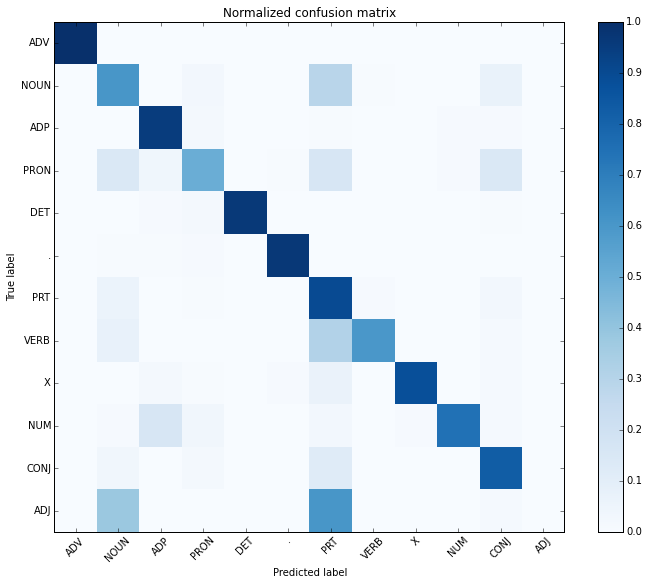

In [41]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test_actual, y_test_hat)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [ ]:
from https://github.com/slavpetrov/universal-pos-tags

VERB - verbs (all tenses and modes)
NOUN - nouns (common and proper)
PRON - pronouns 
ADJ - adjectives
ADV - adverbs
ADP - adpositions (prepositions and postpositions)
CONJ - conjunctions
DET - determiners
NUM - cardinal numbers
PRT - particles or other function words
X - other: foreign words, typos, abbreviations
. - punctuation


In [ ]:

                    if save_model_path is not None:
                        # save the best model
                        with open(save_model + '.pkl', 'w') as f:
                            cPickle.dump(classifier, f)
                        print(save)



        .. math::

            \frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
            \frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|}
                \log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
            \ell (\theta=\{W,b\}, \mathcal{D})



#     n_test_batches = test_set_x.get_value(borrow=True).shape[0] / batch_size

# def predict():
#     """
#     An example of how to load a trained model and use it
#     to predict labels.
#     """

#     # load the saved model
#     classifier = cPickle.load(open('best_model.pkl'))

#     # compile a predictor function
#     predict_model = theano.function(
#         inputs=[classifier.input],
#         outputs=classifier.y_pred)

#     # We can test it on some examples from test test
#     dataset='mnist.pkl.gz'
#     datasets = load_data(dataset)
#     test_set_x, test_set_y = datasets[2]
#     test_set_x = test_set_x.get_value()

#     predicted_values = predict_model(test_set_x[:10])
#     print ("Predicted values for the first 10 examples in test set:")
#     print predicted_values


# test it on the test set -- TODO: testing should be done outside of training -- move this
#                     test_losses = [test_model(i)
#                                    for i in xrange(n_test_batches)]
#                     test_score = numpy.mean(test_losses)

#                     print(
#                         (
#                             '     epoch %i, minibatch %i/%i, test error of'
#                             ' best model %f %%'
#                         ) %
#                         (
#                             epoch,
#                             minibatch_index + 1,
#                             n_train_batches,
#                             test_score * 100.
#                         )
#                     )

#     print 'The code run for %d epochs, with %f epochs/sec' % (
#         epoch, 1. * epoch / (end_time - start_time))
#     print >> sys.stderr, ('The code for file ' +
#                           os.path.split(__file__)[1] +
#                           ' ran for %.1fs' % ((end_time - start_time)))

    # compiling a Theano function that computes the mistakes that are made by
    # the model on a minibatch
#     test_model = theano.function(
#         inputs=[index],
#         outputs=classifier.errors(y),
#         givens={
#             x: test_set_x[index * batch_size: (index + 1) * batch_size],
#             y: test_set_y[index * batch_size: (index + 1) * batch_size]
#         }
#     )


"""
This tutorial introduces logistic regression using Theano and stochastic
gradient descent.

Logistic regression is a probabilistic, linear classifier. It is parametrized
by a weight matrix :math:`W` and a bias vector :math:`b`. Classification is
done by projecting data points onto a set of hyperplanes, the distance to
which is used to determine a class membership probability.

Mathematically, this can be written as:

.. math::
  P(Y=i|x, W,b) &= softmax_i(W x + b) \\
                &= \frac {e^{W_i x + b_i}} {\sum_j e^{W_j x + b_j}}


The output of the model or prediction is then done by taking the argmax of
the vector whose i'th element is P(Y=i|x).

.. math::

  y_{pred} = argmax_i P(Y=i|x,W,b)


This tutorial presents a stochastic gradient descent optimization method
suitable for large datasets.


References:

    - textbooks: "Pattern Recognition and Machine Learning" -
                 Christopher M. Bishop, section 4.3.2

"""